In [321]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# Validation of OSACA
OSACA predicts the minimal (throughput and loop-carried dependency latency) and maximum (critical path latency) instruction execution time for assembly loop bodies, under the assumption that all loads and stores are served by the first level cache.

In this validation study OSACA is compared to measured runtimes of assembly blocks in a large dataset. The prediction accuracy is also compared to three other tools with the same goal im mind: IACA, LLVM-MCA and Ithemal.

## Validation Dataset
The validation dataset is created by compiling several kernels with diffent compilers and optimization flags. Kernels represent the domain of numerical codes and all use double precision floating-point arithmetics. The original high-level C implementations are found in the `validation/kernels` directory and include:
 * Simple load-store heavy kernels: `add`, `copy`, `store`, `striad`, `triad` and `update`
 * Stencils: `2d-5pt`, `3d-7pt`, `3d-27pt` and `3d-r3-11pt`
 * Dependency chain: `gs-2d-5pt` and `sumreduction`
 * Slow arithmetic: `pi` (divide)

All these kernels are compiled with `gcc`, `clang` and `icc` (where applicable) and for each compiler with `-O1`, `-O2`, `-O3` and `-Ofast`, which results in 6-9 variantes per kernel. Additional kernels, compiler and flags can be configured in the `build_and_run.py` script.

## Runtimes and Ground Truth Measurements

Reported cycle runtimes in this notebook –unless otherwise noted– are scaled to high-level code iterations to make them comparable. Raw outputs by the tools will refer to assembly block iterations. Since all provided kernels are double precision based, the `pointer_increment` divided by `8` gives the used scaling factor.

Measured runtimes are gained by traversing 8 to 1024 elements (for a total of 25 million iterations) and selecting the smallest measured runtime out of all executions.

In [322]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.rc = {"figure.dpi": 100}
from pathlib import Path
import pickle
from pprint import pprint, pformat
from itertools import product
import warnings
from functools import reduce

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import pandas as pd
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from IPython.display import display, HTML

    
def boxprint(*args):
    for arg in args:
        display(HTML('<pre style="white-space: pre !important;">{}</pre>'.format(arg)))


pd.set_option('display.max_rows', 1000)

In [323]:
# Load data from build/ directory. The data can either be generated using build_and_run.py or downloaded from a 
# OSACA release from github. Look for releases including validation data archives.
data = []
for p in Path('build/').glob('*/data.pkl'):
    data += pickle.loads(p.read_bytes())
df = pd.DataFrame(data)
archs = ['IVB', 'SKX', 'ZEN', 'ZEN2', 'TX2', 'A64FX']
archs += [a for a in sorted(df.arch.unique()) if a not in archs]
models = ['IACA', 'Ithemal', 'LLVM-MCA', 'OSACA']
kernels = sorted(df.kernel.unique())
compilers = sorted(df.compiler.unique())
cflags_names = sorted(df.cflags_name.unique())

# Add more data
df['worst_runtime'] = df.allruns.map(lambda ar: max([r[2] for r in ar]), na_action='ignore')
for pred in models:
    df[pred+'_err'] = df['best_runtime'] - df[pred+'_prediction']
    df[pred+'_relerr'] = df[pred+'_err']/df['best_runtime']
    df[pred+'_tperr'] = df['best_runtime'] - df[pred+'_throughput']
    df[pred+'_reltperr'] = df[pred+'_tperr']/df['best_runtime']
    df[pred+'_maxport'] = df[pred+'_raw'].map(lambda r: max([(c,p) for p,c in r['port cycles'].items()])[1],
                                              na_action='ignore')
df['instruction count'] = df.OSACA_raw.map(lambda r: len([l for l in r['analyzed kernel'] if l.get('instruction')]))

# Clean up
# TODO do this in pickle files!
del df['IACA_scaled_max'], df['OSACA_scaled_max'], df['LLVM-MCA_scaled_max']
del df['IACA_scaled'], df['OSACA_scaled'], df['LLVM-MCA_scaled']

# Make indexed representation
df_idx = df.set_index(['arch', 'compiler', 'cflags_name', 'kernel'], verify_integrity=True)
df_idx.sort_index(inplace=True)

In [324]:
def get_info(idx, osaca=True, mca=True, iaca=True):
    r = df_idx.loc[idx]
    print("High-level iterations in assembly block:", r.pointer_increment//8)
    print("Measured:", r.best_runtime)
    for m in models:
        print(m, "Predicted:", r[m+'_prediction'], "TP:", r[m+'_throughput'],
              "LCD:", r[m+'_lcd'], "CP:", r[m+'_cp'])
    if osaca:
        boxprint(r.OSACA_raw['output'])
    if mca:
        boxprint(r['LLVM-MCA_raw']['output'])
    if iaca and r['IACA_raw']:
        boxprint(r['IACA_raw']['output'])

In [325]:
# Check for missing instructions in all OSACA analyses
count = 0
for idx, raw in df.OSACA_raw.items():
    if not isinstance(raw, dict): continue
    for l in raw['analyzed kernel']:
        if 'tp_unknown' in l['flags']:
            print(df['arch'][idx]+'/'+df['compiler'][idx]+'/'+df['cflags_name'][idx]+'/'+df['kernel'][idx]+'.marked.s', l['line'])
            count += 1
if not count:
    print("\u2705 All instructions in test dataset are defined in OSACA microarchitecture databaseses.")
else:
    print(count,
          "instructions were not found in OSACA microarchitecture databaseses. "
          "This may lead to unnecessary underpredictions.")

✅ All instructions in test dataset are defined in OSACA microarchitecture databaseses.


## Statistics on Dataset and Measurements
The following histogram/bar plots give an overview on of the wide range of kernels found in the dataset.

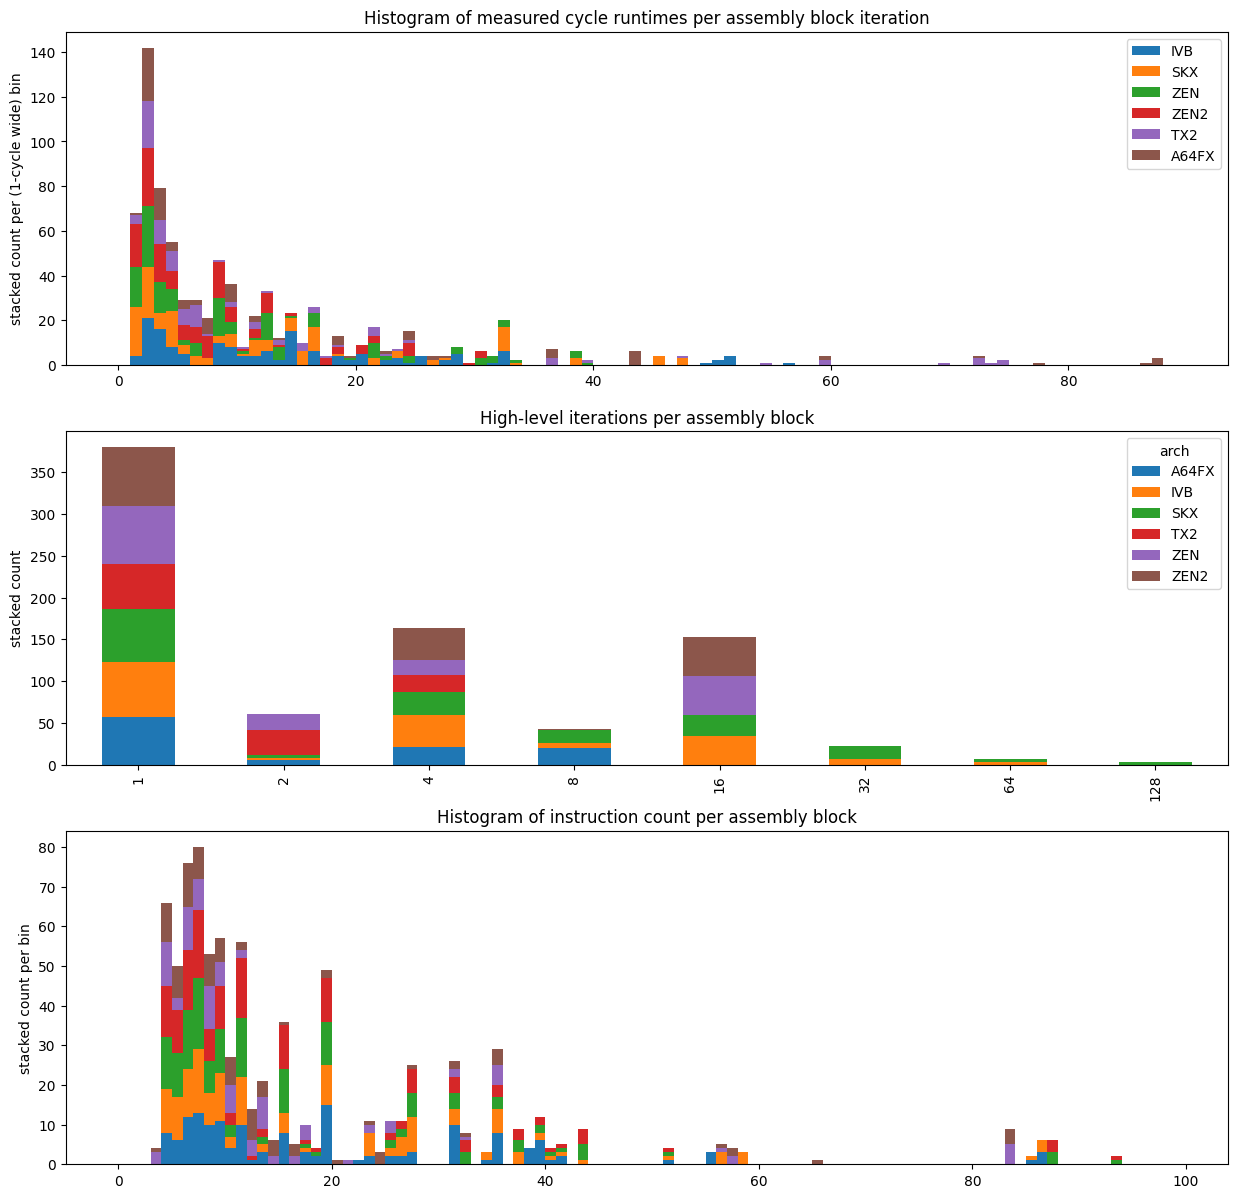

In [326]:
fig, axs = plt.subplots(3, figsize=(15, 15))
df['best_runtime_asm'] = (df.best_runtime * (df.pointer_increment // 8))
axs[0].hist(
    [df.best_runtime_asm[df.arch == a] for a in archs],
    bins=range(0,90),
    label=archs,
    stacked=True,
)
axs[0].legend()
axs[0].set_ylabel('stacked count per (1-cycle wide) bin')
axs[0].set_title('Histogram of measured cycle runtimes per assembly block iteration')

(df.pointer_increment // 8).groupby(df.arch).value_counts().sort_index().unstack('arch').plot(
    kind='bar',
    ax=axs[1],
    stacked=True,
    legend=True
)
axs[1].set_xlabel('')
axs[1].set_ylabel('stacked count')
axs[1].set_title("High-level iterations per assembly block")

axs[2].hist(
    [df['instruction count'][df.arch == a] for a in archs],
    bins=range(0,100),
    label=archs,
    stacked=True,
)
axs[0].legend()
axs[2].set_ylabel('stacked count per bin')
axs[2].set_title("Histogram of instruction count per assembly block");

In [327]:
instruction_forms = reduce(
    set.union,
    df.OSACA_raw.map(lambda r: {l['instruction']+repr([','.join(o.keys()) for o in l['operands']])
                                for l in r['analyzed kernel']
                                if l['instruction']}))
print("A total of",
      len(instruction_forms),
      "different instruction forms (different in name or operand type) found in dataset.")

A total of 114 different instruction forms (different in name or operand type) found in dataset.


The following plot show the convergence of the kernel runtimes towards a minimum plataeu, which is used as ground truth and to be predicted. Noise, toxic loop lengths and runtime increases towards the right are to be expected. Double click on plot to enlarge.

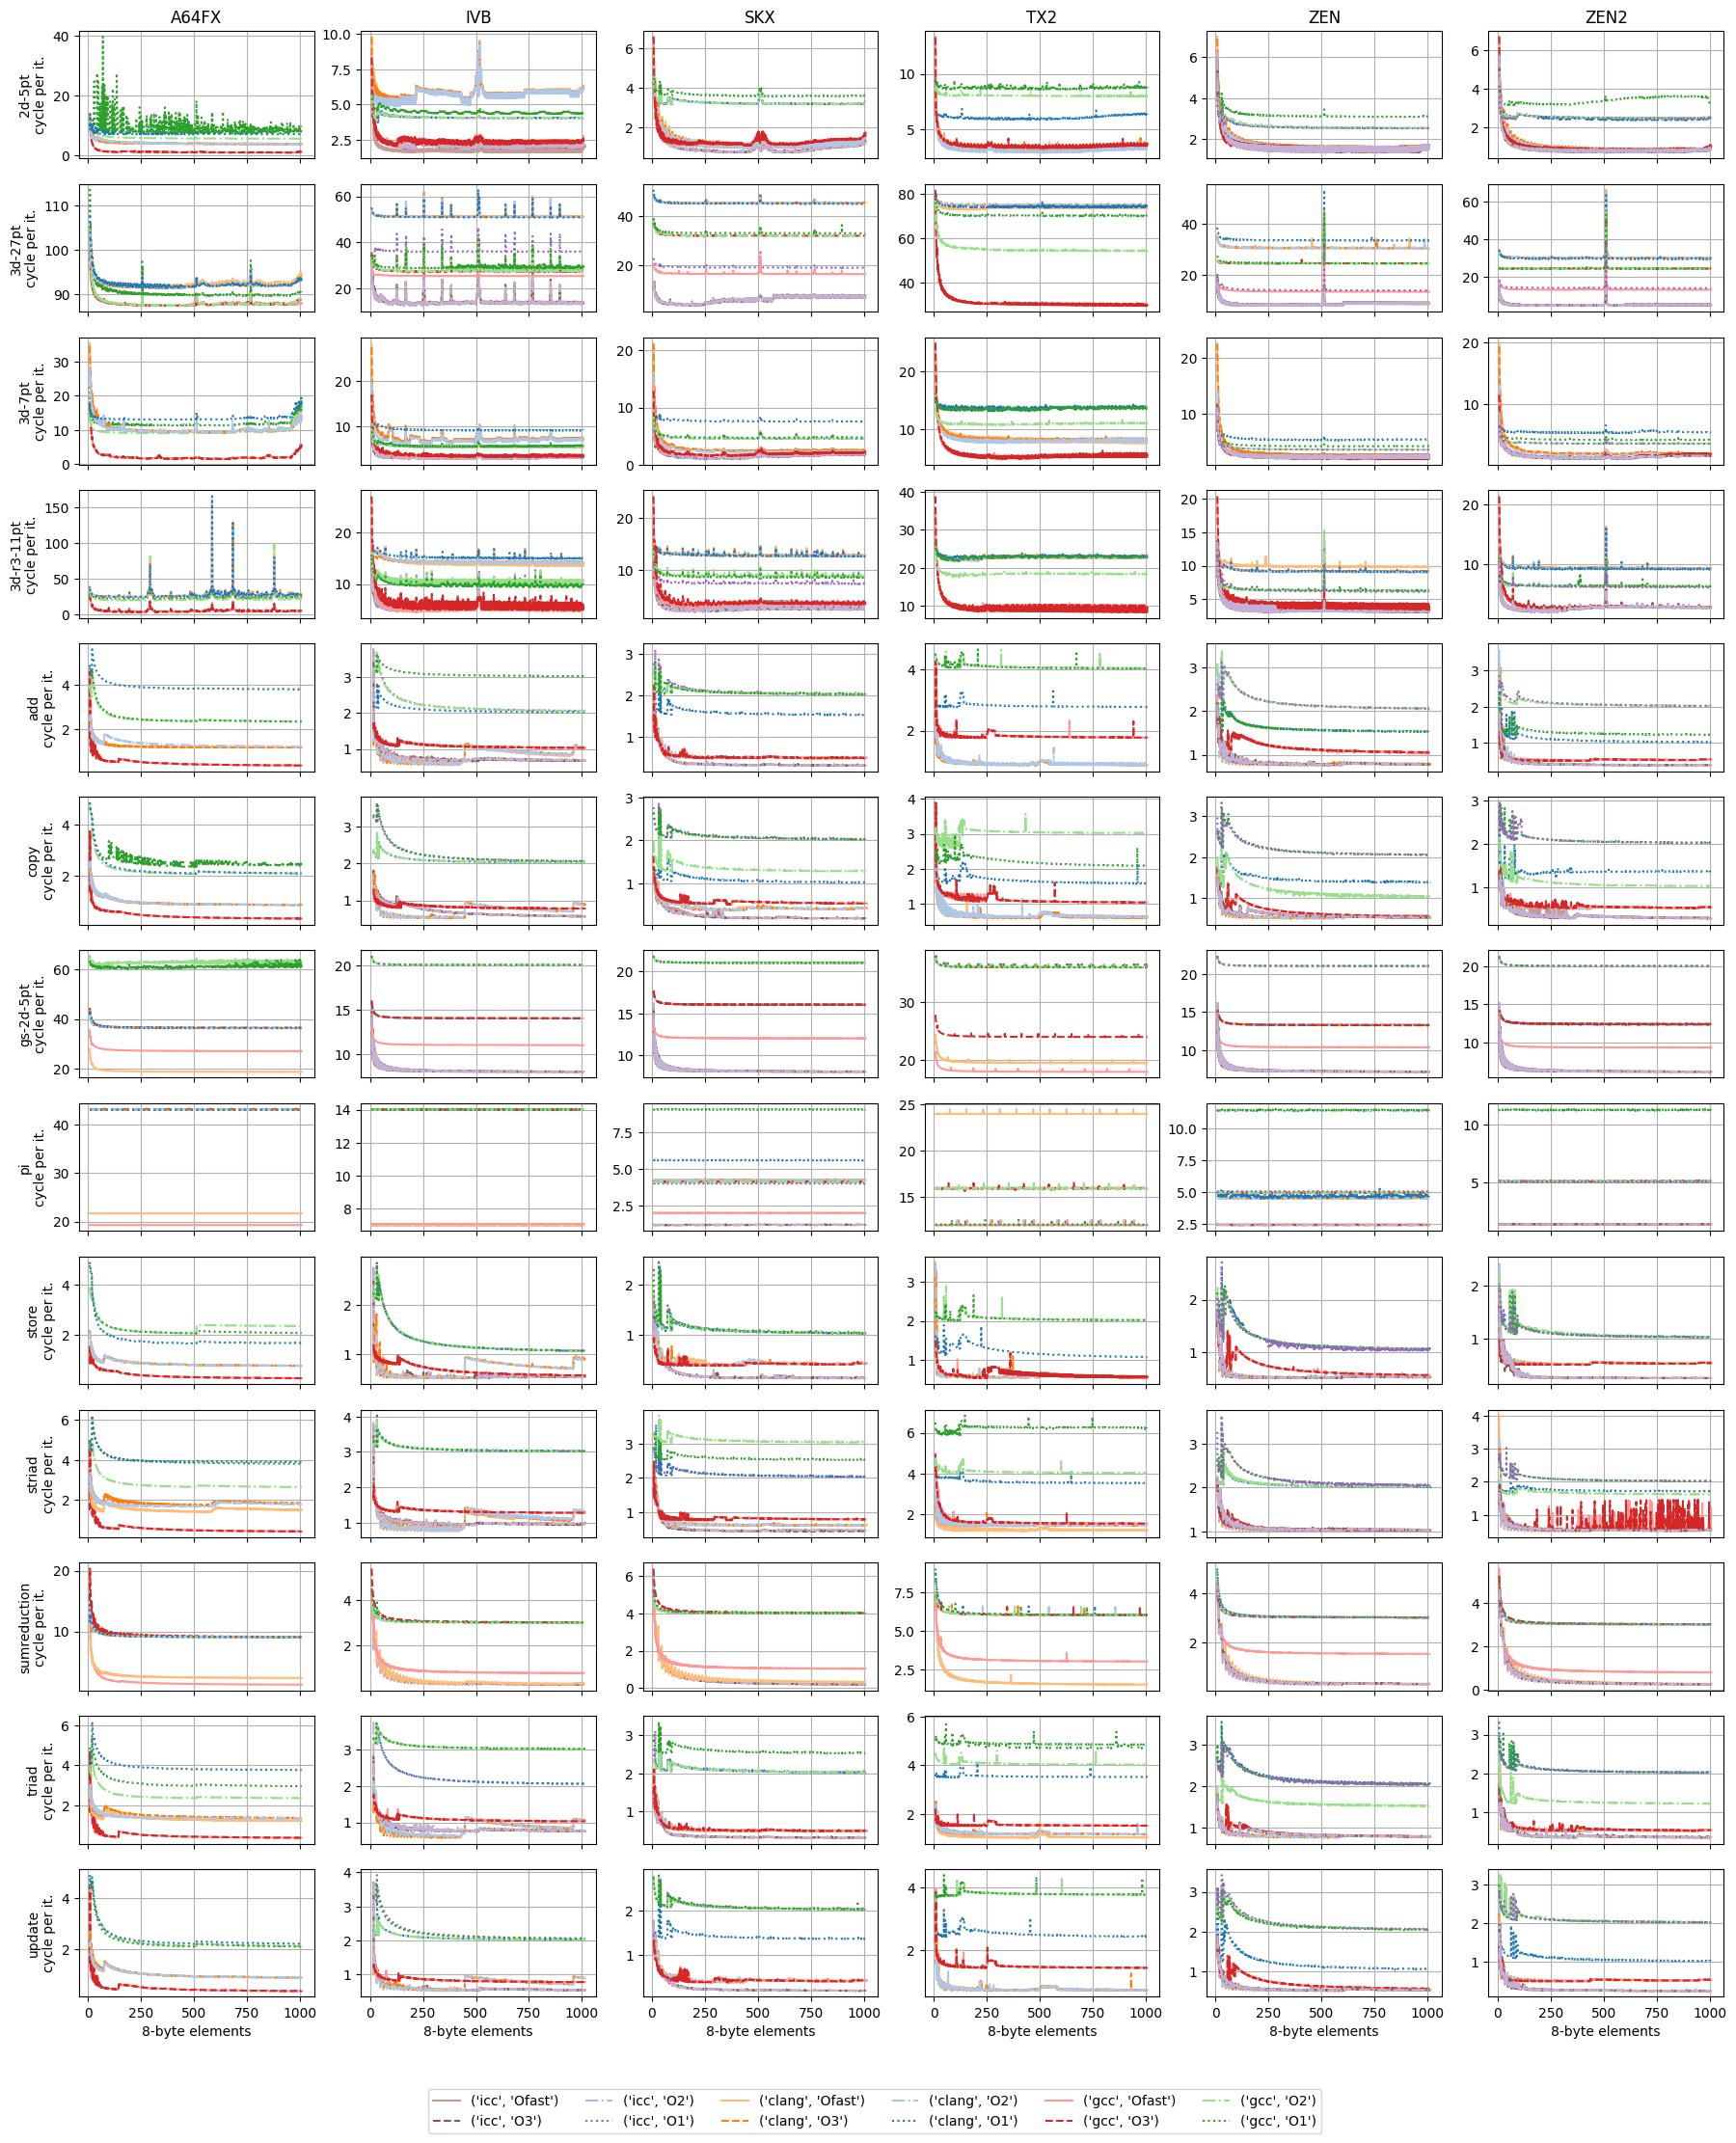

In [328]:
kernels = sorted(df.kernel.unique())
archs = sorted(df.arch.unique())
compiler_flags_prod = list(product(sorted(df.compiler.unique()), sorted(df.cflags_name.unique())))
linestyle_dict = {'Ofast': '-', 'O3': '--', 'O2': '-.', 'O1': ':'}

kernels = sorted(df.kernel.unique())
fig, axs = plt.subplots(len(kernels), len(archs), figsize=(3.5*len(archs)+1,2*len(kernels)+1),
                        sharex=True, dpi=100, squeeze=False)
colors = list(map(list, plt.cm.get_cmap('tab20').colors))
handles = []
for ki, kernel in enumerate(kernels):
    for ai, arch in enumerate(archs):
        for idx, row in df.query('kernel == @kernel and arch == @arch').iterrows():
            if type(row.allruns) is list:
                color_index = compiler_flags_prod.index((row.compiler, row.cflags_name))
                handles = axs[ki,ai].plot(
                    [r[0] for r in row.allruns][:1000], [r[2] for r in row.allruns][:1000],
                    color=colors[color_index],
                    linestyle=linestyle_dict[row.cflags_name],
                    label=str((row.compiler, row.cflags_name)))
            
            if ki == 0:
                axs[ki,ai].set_title(arch)
            elif ki == len(kernels) - 1:
                axs[ki,ai].set_xlabel("8-byte elements")
            if ai == 0:
                axs[ki,ai].set_ylabel(kernel+"\ncycle per it.")
            axs[ki,ai].grid(True)
fig.legend(handles=axs[0,1].lines, loc="lower center", bbox_to_anchor=(0.5, 0.07), ncol=6);

## Evaluation and Statistics on Predictions
Predictions are evaluated with a relative error metric: $\mathrm{rel. error} = (T_\mathrm{measured} - T_\mathrm{predicted})/T_\mathrm{measured}$. Optimally this is to be zero. If the relative error is negative the model has *underpredicted* and failed being a lower bound model, because it predicted a faster runtime than was measured. If the realtive error is positive, the model *overpredicted*, then it is inaccurate and predicted a faster runtime than was measured. A relative prediction error larger than one would indicate a negative absolue runtime prediction and is therefore not possible.

The following table and plot give an overview of the models relative errors in regard to the used dataset. The number of tests depend on the architecture (`icc` does not compile for `aarch64`) and model (IACA and Ithemal do not support non-Intel architectures and Ithemal fails on AVX512 instructions) used.

In [329]:
print("{:>8}  {:>5}  {:>8}  {:>15}  {:>15}  {:>15}".format("model", "tests", "+20% fit", "avg(relerr < 0)", "avg(relerr > 0)", "min(relerr)"))
print("{:>8}  {:>5}  {:>8}  {:>15}  {:>15}  {:>15}".format("", "", "+10% fit", "sum(relerr < 0)", "sum(relerr > 0)", "max(relerr)"))
print(" "*25+"  not lower bound         accuracy\n")
for m in models:
    line = "{:>8}  ".format(m)
    line2 = " "*10
    mr = df[df[m+'_relerr'].notna()]
    # Test count
    line += "{:>5}  ".format(len(mr))
    line2 += " "*7
    # Fit
    line += "{:>8}  ".format(len(mr.query("0 < `"+m+"_relerr` < 0.2")))
    line2 += "{:>8}  ".format(len(mr.query("0 < `"+m+"_relerr` < 0.1")))
    # Sum relative error < 0 (bad)
    relerr_neg = mr[mr[m+'_relerr'] < 0][m+'_relerr']
    if len(relerr_neg):
        line += "{:>15.3f}  ".format(sum(relerr_neg)/len(relerr_neg))
    else:
        line += " "*14+"-  "
    line2 += "{:>15.3f}  ".format(sum(relerr_neg))
    # Sum relative error > 0 (could be better)
    relerr_pos = mr[mr[m+'_relerr'] > 0][m+'_relerr']
    if len(relerr_neg):
        line += "{:>15.3f}  ".format(sum(relerr_pos)/len(relerr_pos))
    else:
        line += " "*14+"-  "
    line2 += "{:>15.3f}  ".format(sum(relerr_pos))
    if not mr[m+'_relerr'].empty:
        line += "{:>15.3f}  ".format(min(mr[m+'_relerr']))
        line2 += "{:>15.3f}  ".format(max(mr[m+'_relerr']))
    print(line)
    print(line2)

   model  tests  +20% fit  avg(relerr < 0)  avg(relerr > 0)      min(relerr)
                 +10% fit  sum(relerr < 0)  sum(relerr > 0)      max(relerr)
                           not lower bound         accuracy

    IACA    312       193           -0.130            0.180           -0.371  
                      136           -1.825           53.602            0.892  
 Ithemal    269        22           -7.708            0.316          -57.589  
                       16        -1503.154           23.373            0.873  
LLVM-MCA    832       139           -0.407            0.352           -2.312  
                       73         -132.606          178.255            0.954  
   OSACA    832       399           -0.006            0.240           -0.080  
                      301           -0.110          194.490            0.954  


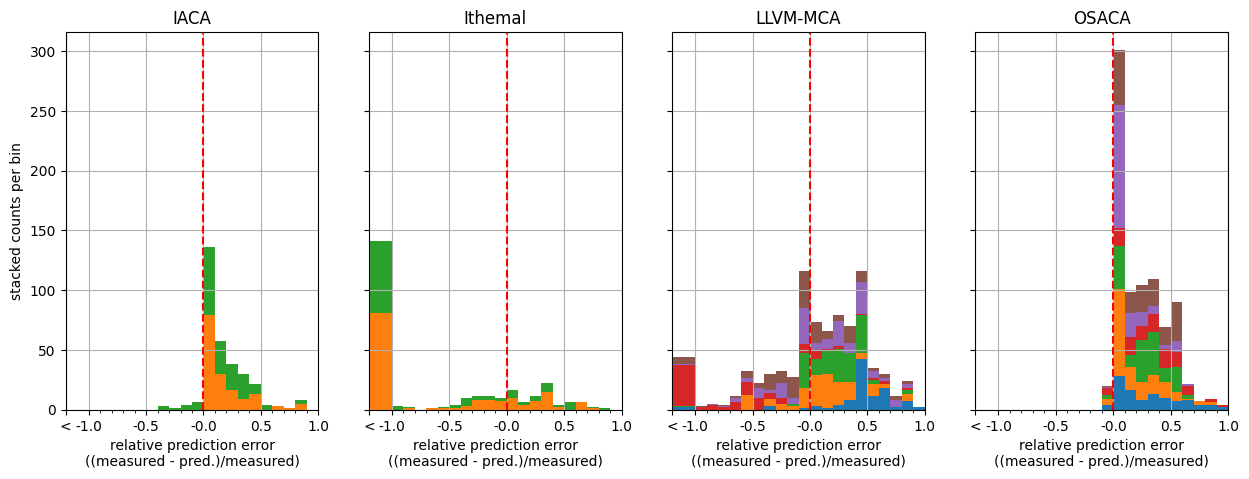

In [330]:
inner_bin_edges = list(np.arange(-1.0, 1.1, 0.1))
fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey='all', sharex='all')
for i, m in enumerate(models):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
        h = axs[i].hist(
            [df[df.arch == a][m+'_relerr'] for a in archs],
            bins=[-100.0]+inner_bin_edges,
            stacked=True,
            label=archs,
        )
    axs[i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
    axs[i].set_xticks(inner_bin_edges, minor=True)
    axs[i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
    axs[i].axvline(0, color='red', linestyle='--')
    if i == 0:
        axs[i].set_ylabel('stacked counts per bin')
    axs[i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
    axs[i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
    axs[i].set_title(m)
    axs[i].grid(True)
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

* IACA shows the best average overprediction with about 18%. It does underpredict, but rearly. Almost two-thirds of the applicable tests are predicted within 20% of the measured runtime.
* Ithemal underpredicts most of the time and gives a reasonable prediction in in less than one-tenth of the sucessfully run test cases.
* LLVM-MCA underpredicts quite often, none the less, most overpredictions are within 0 and +50% of the measured runtime, 35% on average.
* OSACA seldomly under predicts (details on this follow below), and 46% of all test cases show a relative error of 20% or less.

In [331]:
print("{:>8}  {:>5}  {:>8}  {:>15}  {:>15}  {:>15}".format("µarch", "tests", "+20% fit", "avg(relerr < 0)", "avg(relerr > 0)", "min(relerr)"))
print("{:>8}  {:>5}  {:>8}  {:>15}  {:>15}  {:>15}\n".format("", "", "+10% fit", "sum(relerr < 0)", "sum(relerr > 0)", "max(relerr)"))
for a in archs:
    m = 'OSACA'
    line = "{:>8}  ".format(a)
    line2 = " "*10
    mr = df[df[m+'_relerr'].notna()][df.arch == a]
    # Test count
    line += "{:>5}  ".format(len(mr))
    line2 += " "*7
    # Fit
    line += "{:>8}  ".format(len(mr.query("0 < `"+m+"_relerr` < 0.2")))
    line2 += "{:>8}  ".format(len(mr.query("0 < `"+m+"_relerr` < 0.1")))
    # Sum relative error < 0 (bad)
    relerr_neg = mr[mr[m+'_relerr'] < 0][m+'_relerr']
    if len(relerr_neg):
        line += "{:>15.3f}  ".format(sum(relerr_neg)/len(relerr_neg))
    else:
        line += " "*14+"-  "
    line2 += "{:>15.3f}  ".format(sum(relerr_neg))
    # Sum relative error > 0 (could be better)
    relerr_pos = mr[mr[m+'_relerr'] > 0][m+'_relerr']
    if len(relerr_neg):
        line += "{:>15.3f}  ".format(sum(relerr_pos)/len(relerr_pos))
    else:
        line += " "*14+"-  "
    line2 += "{:>15.3f}  ".format(sum(relerr_pos))
    if not mr[m+'_relerr'].empty:
        line += "{:>15.3f}  ".format(min(mr[m+'_relerr']))
        line2 += "{:>15.3f}  ".format(max(mr[m+'_relerr']))
    print(line)
    print(line2)

   µarch  tests  +20% fit  avg(relerr < 0)  avg(relerr > 0)      min(relerr)
                 +10% fit  sum(relerr < 0)  sum(relerr > 0)      max(relerr)

   A64FX    104        44           -0.025            0.313           -0.080  
                       28           -0.102           31.312            0.941  
     IVB    156        93           -0.000            0.194           -0.000  
                       73           -0.001           29.280            0.806  
     SKX    156        46           -0.002            0.268           -0.002  
                       36           -0.005           40.933            0.618  
     TX2    104        30           -0.000            0.345           -0.000  
                       15           -0.002           33.794            0.954  
     ZEN    156       123           -0.000            0.117           -0.000  
                      103           -0.000           18.194            0.647  
    ZEN2    156        63           -0.001            0

This breakdown of OSACA predictions by archiecture reveals that IVB and ZEN are best predicted and TX2 and A64FX worst.

## Intel Ivy Bridge (IVB) and Skylake X (SKX)

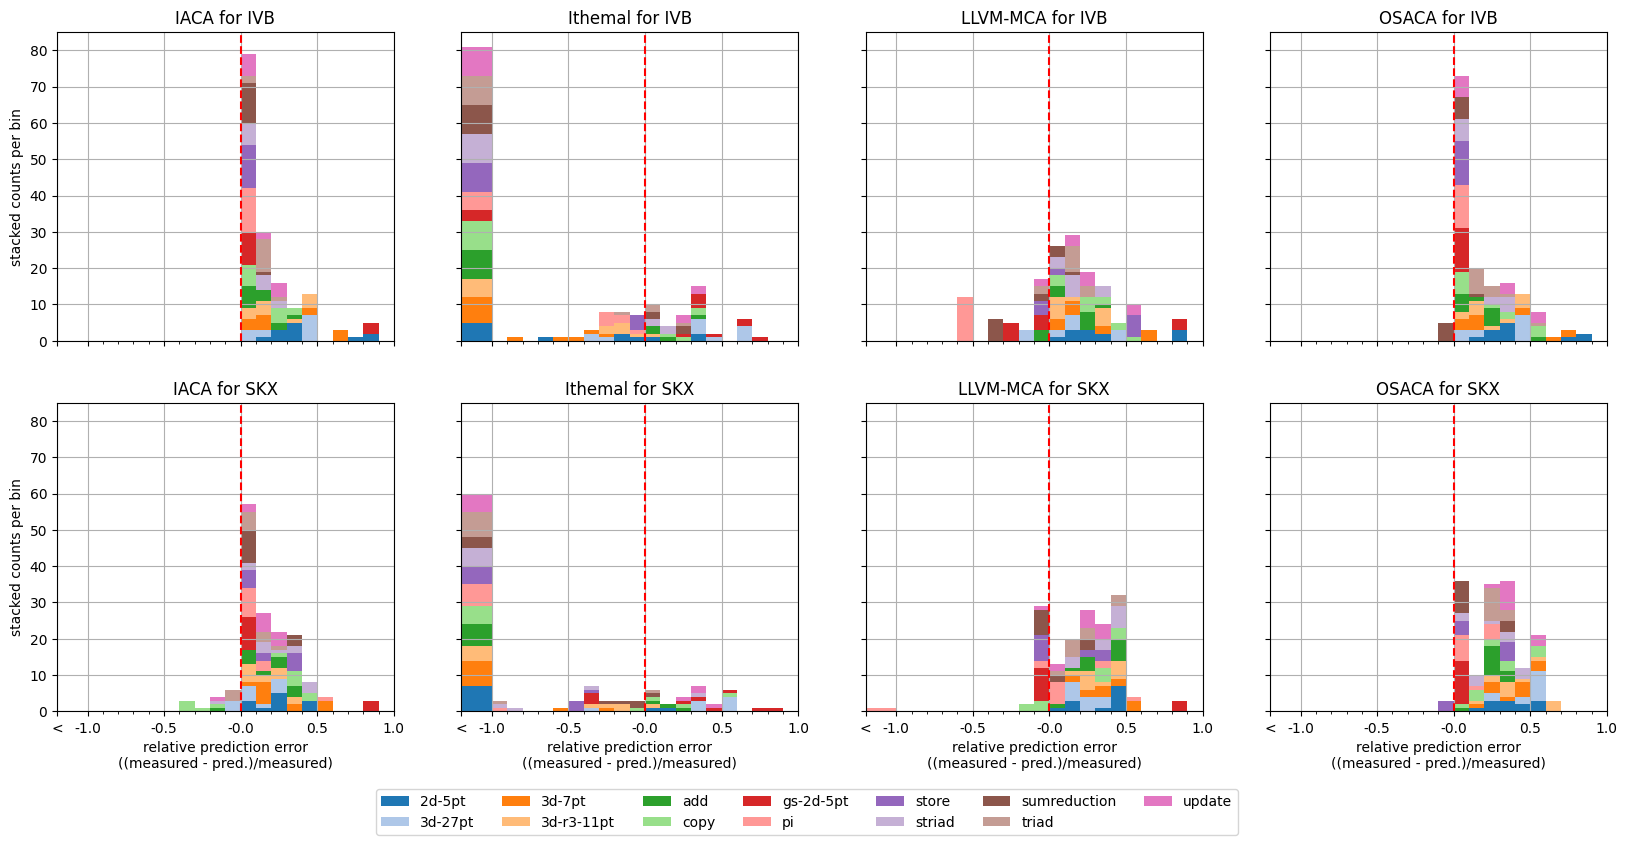

In [332]:
inner_bin_edges = list(np.arange(-1.0, 1.1, 0.1))
colors = list(map(list, plt.cm.get_cmap('tab20').colors))
fig, axs = plt.subplots(2, len(models), figsize=(20, 9), sharey='all', sharex='all')
for j, a in enumerate(['IVB', 'SKX']):
    for i, m in enumerate(models):
        h = axs[j,i].hist(
            [df[df.arch == a][m+'_relerr'][df.kernel == k] for k in kernels],
            bins=[-100.0]+inner_bin_edges,
            stacked=True,
            label=kernels,
            color=colors[:len(kernels)]
        )
        axs[j,i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
        axs[j,i].set_xticks(inner_bin_edges, minor=True)
        axs[j,i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
        axs[j,i].axvline(0, color='red', linestyle='--')
        if i == 0:
            axs[j,i].set_ylabel('stacked counts per bin')
            axs[j,i].set_yticks(range(0, 81, 10))
        if j == axs.shape[0]-1:
            axs[j,i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
            axs[j,i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
        axs[j,i].set_title(m+" for "+a)
        axs[j,i].grid(True)
fig.legend(h[2], kernels, ncol=7, loc="lower center", bbox_to_anchor=(.5, -0.02));
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

Predictions on Skylake are challenging to both LLVM-MCA and OSACA, while IACA gives good results. Looking at individual IACA prediction reports quickly reveals that IACA assumes many of the more-than-20%-off OSACA predictions to be bound by a frontend bottleneck. Since frontend bottlenecks are not modled by OSACA, this is to be expected. While this does not explain the whole discrepancy, some can be accounted to this, as shown in the following plot.

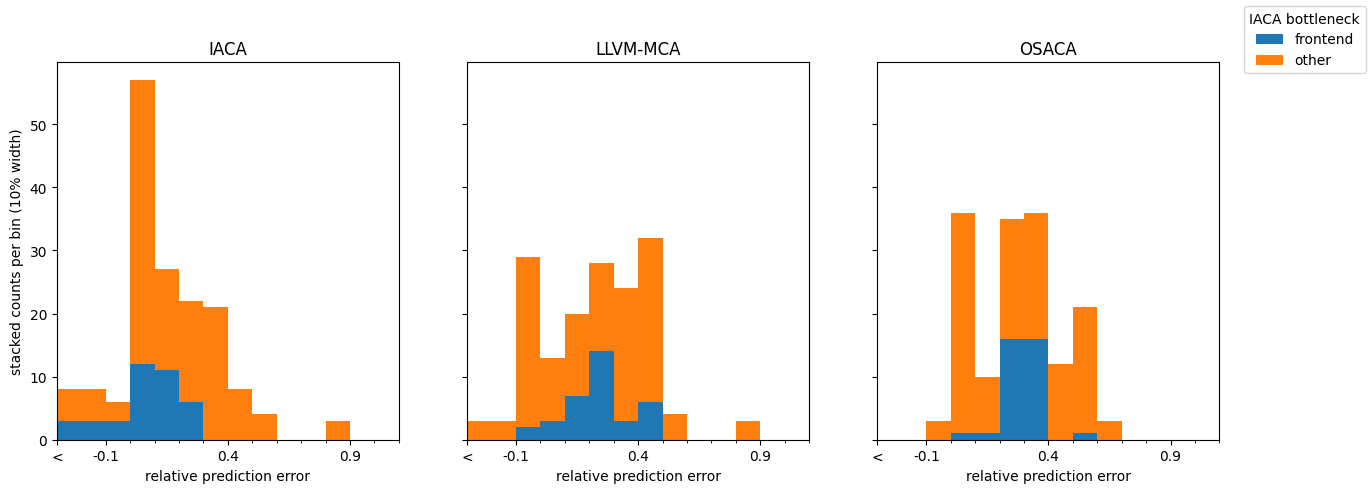

In [333]:
inner_bin_edges = list(np.arange(-0.1, 1.1, 0.1))
df['IACA_frontend'] = df.IACA_raw.map(lambda r: "FrontEnd" in r['output'], na_action='ignore')
df.IACA_frontend.fillna(False, inplace=True)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].hist(
    [df[df.arch == "SKX"]['IACA_relerr'][df.IACA_frontend == b] for b in [True, False]],
    bins=[-100.0]+inner_bin_edges,
    stacked=True,
)
axs[0].set_ylabel("stacked counts per bin (10% width)")
axs[0].set_title("IACA")

axs[1].hist(
    [df[df.arch == "SKX"]['LLVM-MCA_relerr'][df.IACA_frontend == b] for b in [True, False]],
    bins=[-100.0]+inner_bin_edges,
    stacked=True,
)
axs[1].set_title("LLVM-MCA")


h = axs[2].hist(
    [df[df.arch == "SKX"]['OSACA_relerr'][df.IACA_frontend == b] for b in [True, False]],
    bins=[-100.0]+inner_bin_edges,
    stacked=True,
)
axs[2].set_title("OSACA")

for i in range(3):
    axs[i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
    axs[i].set_xticks(inner_bin_edges, minor=True)
    axs[i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
    axs[i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
    axs[i].set_xlabel("relative prediction error")
fig.legend(h[2], ["frontend", "other"], title="IACA bottleneck");

## AMD Zen and Zen2

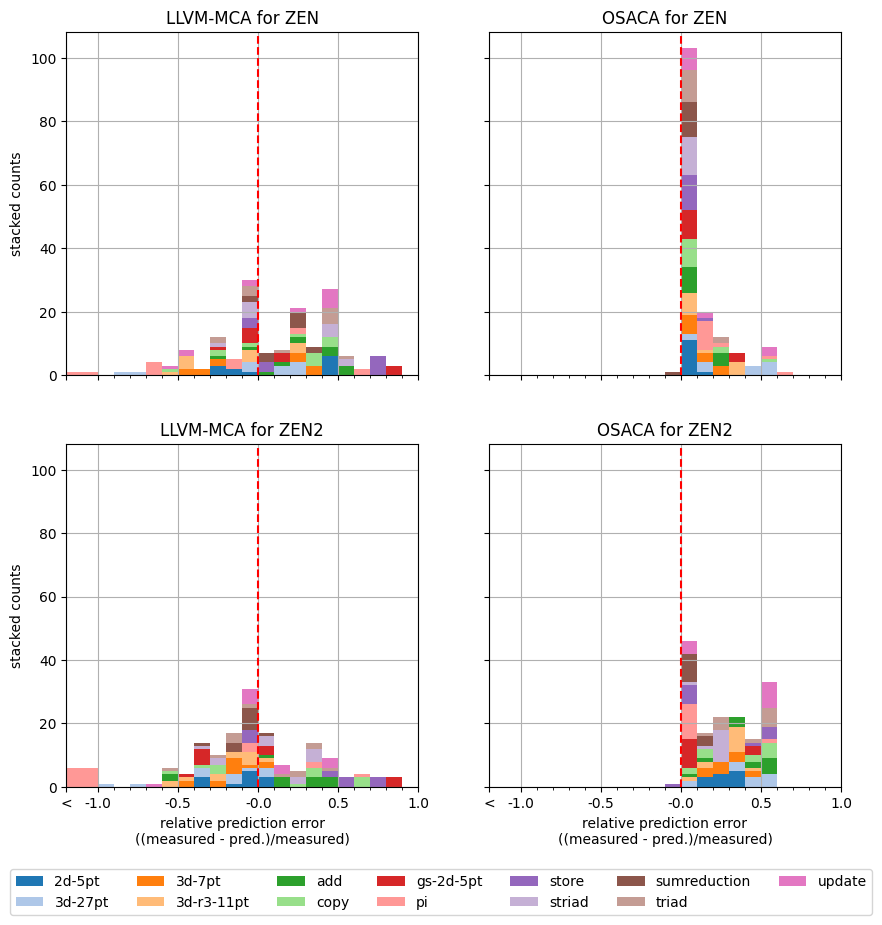

In [334]:
inner_bin_edges = list(np.arange(-1.0, 1.1, 0.1))
colors = list(map(list, plt.cm.get_cmap('tab20').colors))
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey='all', sharex='all')
for j, a in enumerate(['ZEN', 'ZEN2']):
    for i, m in enumerate(['LLVM-MCA','OSACA']):
        h = axs[j,i].hist(
            [df[df.arch == a][m+'_relerr'][df.kernel == k] for k in kernels],
            bins=[-100.0]+inner_bin_edges+[100.0],
            stacked=True,
            label=kernels,
            color=colors[:len(kernels)],
        )
        axs[j,i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
        axs[j,i].set_xticks(inner_bin_edges, minor=True)
        axs[j,i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
        axs[j,i].axvline(0, color='red', linestyle='--')
        if i == 0:
            axs[j,i].set_ylabel('stacked counts')
        if j == axs.shape[0]-1:
            axs[j,i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
            axs[j,i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
        axs[j,i].set_title(m+" for "+a)
        axs[j,i].grid(True)
fig.legend(h[2], kernels, ncol=7, loc="lower center", bbox_to_anchor=(.5, -0.01));
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

Kernels on the Zen architecture are very well predicted. What stands out, are the 3d-27pt kernels with more than 40% relative error:

In [335]:
df_idx.query("OSACA_relerr > 0.4 and kernel == '3d-27pt' and arch == 'ZEN'")[
    ['instruction count', 'best_runtime', 'OSACA_throughput', 'OSACA_lcd', 'OSACA_cp', 'OSACA_relerr', 'LLVM-MCA_relerr']
]

instruction count  best_runtime  \
arch compiler cflags_name kernel                                     
ZEN  clang    O1          3d-27pt                 93     33.432250   
              O2          3d-27pt                 87     30.513532   
              O3          3d-27pt                 87     30.522349   
              Ofast       3d-27pt                 87     30.313140   
     gcc      O1          3d-27pt                 40     24.542994   
              O2          3d-27pt                 39     24.549206   
              O3          3d-27pt                 39     24.538473   

                                   OSACA_throughput  OSACA_lcd  OSACA_cp  \
arch compiler cflags_name kernel                                           
ZEN  clang    O1          3d-27pt              14.0        1.0      79.0   
              O2          3d-27pt              14.5        2.0      79.0   
              O3          3d-27pt              14.5        2.0      79.0   
              Ofast       3d-27pt              14.5        2.0      79.0   
     gcc      O1          3d-27pt              14.0        1.0      79.0   
              O2          3d-27pt              13.5        1.0      79.0   
              O3          3d-27pt              13.5        1.0      79.0   

                                   OSACA_relerr  LLVM-MCA_relerr  
arch compiler cflags_name kernel                                  
ZEN  clang    O1          3d-27pt      0.581243         0.239357  
              O2          3d-27pt      0.524801         0.167910  
              O3          3d-27pt      0.524938         0.168151  
              Ofast       3d-27pt      0.521660         0.162409  
     gcc      O1          3d-27pt      0.429572        -0.029622  
              O2          3d-27pt      0.450084        -0.028547  
              O3          3d-27pt      0.449844        -0.028996

All of them contain a single chain of 26 loads are accumulated into the same register. They therefore have a very long critical path in relation to the throughput. This would require the out-of-order engine to overlap almost 6 complete iterations, with many shadow registers, to fully utilize the load and AVX add units. When compiled with gcc Ofast or icc, the dependency chain is broken up and prediction becomes accurate.

On ZEN2 relative errors are generally greater than on ZEN, 3d-27pt has similar problems, but other have errors > 50%:

In [336]:
df_idx.query("OSACA_relerr > 0.5 and kernel != '3d-27pt' and arch == 'ZEN2'")[
    ['instruction count', 'best_runtime', 'best_length', 'OSACA_throughput', 'OSACA_cp', 'OSACA_relerr', 'LLVM-MCA_relerr']
]

instruction count  best_runtime  \
arch compiler cflags_name kernel                                    
ZEN2 clang    O1          triad                   6      2.005150   
              O2          copy                   11      0.506566   
                          store                   7      0.506572   
                          update                 11      0.506086   
              O3          store                   7      0.506105   
                          triad                  15      0.506079   
                          update                 11      0.505135   
              Ofast       add                    15      0.505614   
                          store                   7      0.505468   
                          triad                  15      0.505634   
                          update                 11      0.505616   
     gcc      O1          copy                    6      2.024413   
                          pi                     11     11.156682   
                          update                  6      2.021849   
              O2          add                     7      2.021123   
                          update                  6      2.026369   
              O3          add                     6      0.505604   
                          copy                    5      0.524468   
                          triad                   6      0.524901   
                          update                  5      0.503385   
              Ofast       add                     6      0.505587   
                          copy                    5      0.524399   
                          store                   4      0.505589   
                          triad                   6      0.524969   
                          update                  5      0.501196   
     icc      O1          add                     6      2.024874   
                          copy                    5      2.023416   
                          triad                   6      2.021751   
                          update                  5      2.024912   

                                  best_length  OSACA_throughput  OSACA_cp  \
arch compiler cflags_name kernel                                            
ZEN2 clang    O1          triad          3322              1.00    6.0000   
              O2          copy            192              0.25    0.2500   
                          store           308              0.25    0.0625   
                          update          352              0.25    0.1875   
              O3          store           386              0.25    0.0625   
                          triad           160              0.25    0.3750   
                          update          438              0.25    0.1875   
              Ofast       add             387              0.25    0.4375   
                          store           209              0.25    0.0625   
                          triad           387              0.25    0.5625   
                          update          372              0.25    0.1875   
     gcc      O1          copy            948              1.00    5.0000   
                          pi              649              5.00   32.0000   
                          update         1024              1.00    3.0000   
              O2          add             961              1.00    7.0000   
                          update          944              1.00    3.0000   
              O3          add             346              0.25    1.7500   
                          copy            911              0.25    1.0000   
                          triad           946              0.25    2.2500   
                          update          346              0.25    0.7500   
              Ofast       add             406              0.25    1.7500   
                          copy            311              0.25    1.0000   
                          store           368 

These are mosly very short kernels (add, copy, store, triad and update with 4-7 instructions) and they may suffer greatly from instructions missalignment. This can be fixed manually, but even telling icc and gcc via a command line flag to performe proper 16-byte alignment on loops, did not fix this for all cases. clang unfortunatly has no such flag.

Penalties resulting from instruction missalignment can not be predicted, because OSACA and LLVM-MCA analyze the assembly code and not the binary object file.

## ARM-based Fujitsu A64FX and Cavium ThunderX2 (TX2)

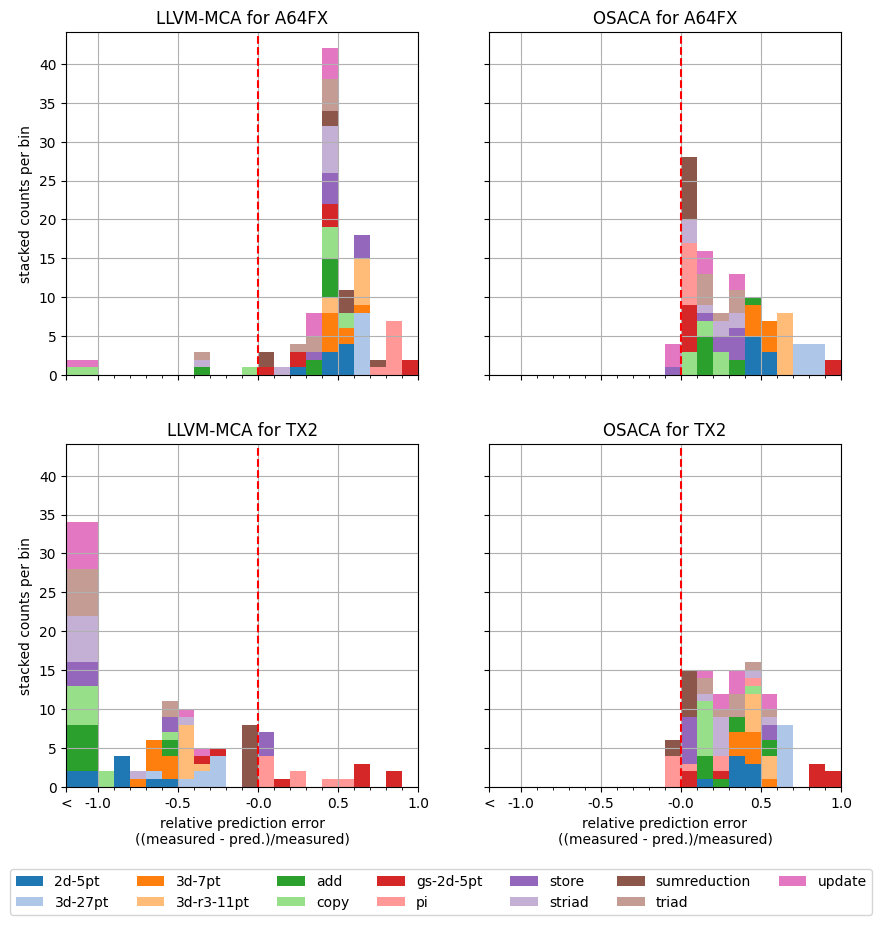

In [337]:
inner_bin_edges = list(np.arange(-1.0, 1.1, 0.1))
colors = list(map(list, plt.cm.get_cmap('tab20').colors))
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey='all', sharex='all')
for j, a in enumerate(['A64FX', 'TX2']):
    for i, m in enumerate(['LLVM-MCA','OSACA']):
        h = axs[j,i].hist(
            [df[df.arch == a][m+'_relerr'][df.kernel == k] for k in kernels],
            bins=[-100.0]+inner_bin_edges+[100.0],
            stacked=True,
            label=kernels,
            color=colors[:len(kernels)],
        )
        axs[j,i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
        axs[j,i].set_xticks(inner_bin_edges, minor=True)
        axs[j,i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
        axs[j,i].axvline(0, color='red', linestyle='--')
        if i == 0:
            axs[j,i].set_ylabel('stacked counts per bin')
        if j == axs.shape[0]-1:
            axs[j,i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
            axs[j,i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
        axs[j,i].set_title(m+" for "+a)
        axs[j,i].grid(True)
fig.legend(h[2], kernels, ncol=7, loc="lower center", bbox_to_anchor=(.5, -0.01));
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

The A64FX arechitecture has a problem with instruction scheduling. OSACA therfore assumes that naive scheduling is applied (scheduling to ports is based on a static probability). This generally improves predictions, but lead to four kernels showing underpredictions.

Kernel limited by a loop carried dependency (pi, gs-2d-5pt and sumreduction) are predicted very well, if the LCD is detected. Load intensive stencil kernels (3d-27pt, 3d-r3-11pt, 3d-7pt and 2d-5pt) make up almost all relative errors > 40%.

The prediction accuracy for the TX2 is quite underwhelming. This is, at least in part, owed to missing documentation on instruction performance. The used information was manually derived and is tainted with uncertainty.

## Underpredictions by OSACA
The following table shows all underpredicitons, which contradict the light-speed/lower-bound model paradim:

In [338]:
# Runtime less than TP or LCD, this violates the model assumption:
df_idx.query("best_runtime < OSACA_throughput or best_runtime < OSACA_lcd").sort_values('OSACA_relerr')[
    ['best_runtime', 'OSACA_prediction', 'OSACA_relerr']]

best_runtime  OSACA_prediction  \
arch  compiler cflags_name kernel                                         
A64FX clang    O1          store             1.620002             1.750   
               O2          update            0.864065             0.875   
               O3          update            0.871200             0.875   
               Ofast       update            0.871200             0.875   
SKX   icc      O2          store             0.124775             0.125   
               Ofast       store             0.124783             0.125   
               O3          store             0.124783             0.125   
ZEN2  icc      O2          store             0.249745             0.250   
TX2   gcc      Ofast       pi               11.996016            12.000   
      clang    O1          pi               11.996100            12.000   
               O2          pi               11.996108            12.000   
               O3          pi               11.996130            12.000   
ZEN   clang    O1          sumreduction      2.999438             3.000   
TX2   clang    O2          sumreduction      5.999024             6.000   
               O3          sumreduction      5.999029             6.000   
IVB   clang    O1          sumreduction      2.999634             3.000   
      gcc      O2          sumreduction      2.999639             3.000   
      icc      O1          sumreduction      2.999676             3.000   
      clang    O3          sumreduction      2.999714             3.000   
               O2          sumreduction      2.999747             3.000   

                                         OSACA_relerr  
arch  compiler cflags_name kernel                      
A64FX clang    O1          store            -0.080246  
               O2          update           -0.012655  
               O3          update           -0.004362  
               Ofast       update           -0.004362  
SKX   icc      O2          store            -0.001805  
               Ofast       store            -0.001742  
               O3          store            -0.001738  
ZEN2  icc      O2          store            -0.001023  
TX2   gcc      Ofast       pi               -0.000332  
      clang    O1          pi               -0.000325  
               O2          pi               -0.000324  
               O3          pi               -0.000323  
ZEN   clang    O1          sumreduction     -0.000187  
TX2   clang    O2          sumreduction     -0.000163  
               O3          sumreduction     -0.000162  
IVB   clang    O1          sumreduction     -0.000122  
      gcc      O2          sumreduction     -0.000120  
      icc      O1          sumreduction     -0.000108  
      clang    O3          sumreduction     -0.000095  
               O2          sumreduction     -0.000084

The first two underpredicted kernels on A64FX are the only ones which show an error "greater" than 0.5%. Both kernels are very unbalanced port-wise, which could be avoided by better scheduling. Usually optimal scheduling is assumed by OSACA, but naive scheduling has proven to be better suited on A64FX, at the cost of these rare underpredictions.

All other kernels show a very small underprediction, which may be related to underreprting of the processor frequency during measurement or even rounding errors (e.g., 2.9997 vs 3.000).

## Worst predictions by OSACA
Here are all predictions where OSACA has a relative errror of at least 50%:

In [347]:
# Runtime more than 110% of CP, this may be a model error:
df.query("OSACA_relerr > 0.5").sort_values('OSACA_relerr', ascending=False)[[
    'arch', 'compiler', 'cflags_name', 'kernel',
    'best_runtime', 'instruction count', 'OSACA_relerr',
    'OSACA_throughput', 'OSACA_lcd',
    'IACA_prediction', 'LLVM-MCA_prediction']
]

,arch,compiler,cflags_name,kernel,best_runtime,instruction count,OSACA_relerr,OSACA_throughput,OSACA_lcd,IACA_prediction,LLVM-MCA_prediction
770,TX2,clang,O2,gs-2d-5pt,36.008947,11,0.953761,1.6650,0.5000,NaN,5.615000
762,TX2,clang,O3,gs-2d-5pt,36.007412,13,0.944456,2.0000,0.5000,NaN,6.105000
183,A64FX,gcc,O2,gs-2d-5pt,59.658430,13,0.941333,3.5000,2.0000,NaN,3.270000
194,A64FX,gcc,O1,gs-2d-5pt,59.646095,13,0.941321,3.5000,2.0000,NaN,2.770000
754,TX2,clang,Ofast,gs-2d-5pt,19.525823,13,0.897572,2.0000,0.5000,NaN,6.105000
778,TX2,clang,O1,gs-2d-5pt,36.008679,13,0.888916,4.0000,1.0000,NaN,12.210000
810,TX2,gcc,O1,gs-2d-5pt,36.008291,16,0.861143,5.0000,1.0000,NaN,13.220000
255,A64FX,gcc,O1,3d-27pt,89.427077,65,0.818288,16.2500,1.0000,NaN,31.450000
254,A64FX,gcc,O2,3d-27pt,87.283464,57,0.810961,16.5000,1.0000,NaN,33.200000
253,A64FX,gcc,O3,3d-27pt,87.259060,57,0.810908,16.5000,1.0000,NaN,33.200000
